# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [11]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [103]:
# Import essential libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os
import random
import glob
import shutil

Load the dataset.

In [14]:
# Load and unzip the dataset

!unzip data.zip
# !ls -R

Archive:  data.zip
  inflating: data/Food_Waste/file_931.png  
  inflating: data/Food_Waste/file_663.png  
  inflating: data/Food_Waste/file_468.png  
  inflating: data/Food_Waste/file_659.png  
  inflating: data/Food_Waste/file_321.png  
  inflating: data/Food_Waste/file_88.png  
  inflating: data/Food_Waste/file_156.png  
  inflating: data/Food_Waste/file_211.png  
  inflating: data/Food_Waste/file_538.png  
  inflating: data/Food_Waste/file_36.png  
  inflating: data/Food_Waste/file_871.png  
  inflating: data/Food_Waste/file_56.png  
  inflating: data/Food_Waste/file_696.png  
  inflating: data/Food_Waste/file_427.png  
  inflating: data/Food_Waste/file_861.png  
  inflating: data/Food_Waste/file_681.png  
  inflating: data/Food_Waste/file_295.png  
  inflating: data/Food_Waste/file_963.png  
  inflating: data/Food_Waste/file_51.png  
  inflating: data/Food_Waste/file_634.png  
  inflating: data/Food_Waste/file_948.png  
  inflating: data/Food_Waste/file_462.png  
  inflating: data

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [19]:
# Create a function to load the raw images

def load_raw_images(data_dir):
  x=[]
  y=[]
  label_names=sorted(os.listdir(data_dir))
  for label in label_names:
    label_folder=os.path.join(data_dir, label)
    if not os.path.isdir(label_folder):
      continue
    for filename in os.listdir(label_folder):
      img_path=os.path.join(label_folder, filename)
      try:
        img = Image.open(img_path).convert('RGB')
        x.append(img)
        y.append(label)
      except Exception as e:
        continue
  return x, y, label_names

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [22]:
# Get the images and their labels
data_dir = 'data'
X_raw, y_raw, label_names = load_raw_images(data_dir)

print(f'Number of images: {len(X_raw)}')
print(f'Number of labels: {len(label_names)}')
print(f'Label names: {label_names}')

Number of images: 7625
Number of labels: 7
Label names: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


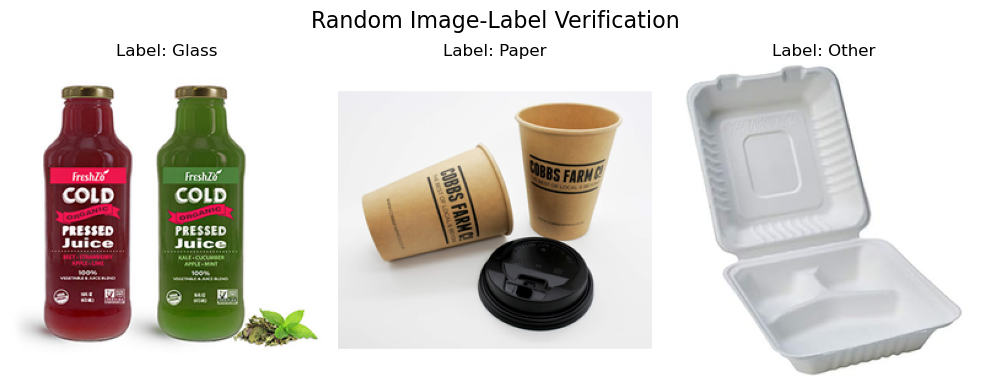

In [91]:
# Random image label verification for 3 images
indices = random.sample(range(len(X_raw)), 3)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(indices):
    plt.subplot(1, 3, i + 1)
    plt.imshow(X_raw[idx])
    plt.title(f"Label: {y_raw[idx]}")
    plt.axis("off")
plt.suptitle("Random Image-Label Verification", fontsize=16)
plt.tight_layout()
plt.show()

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

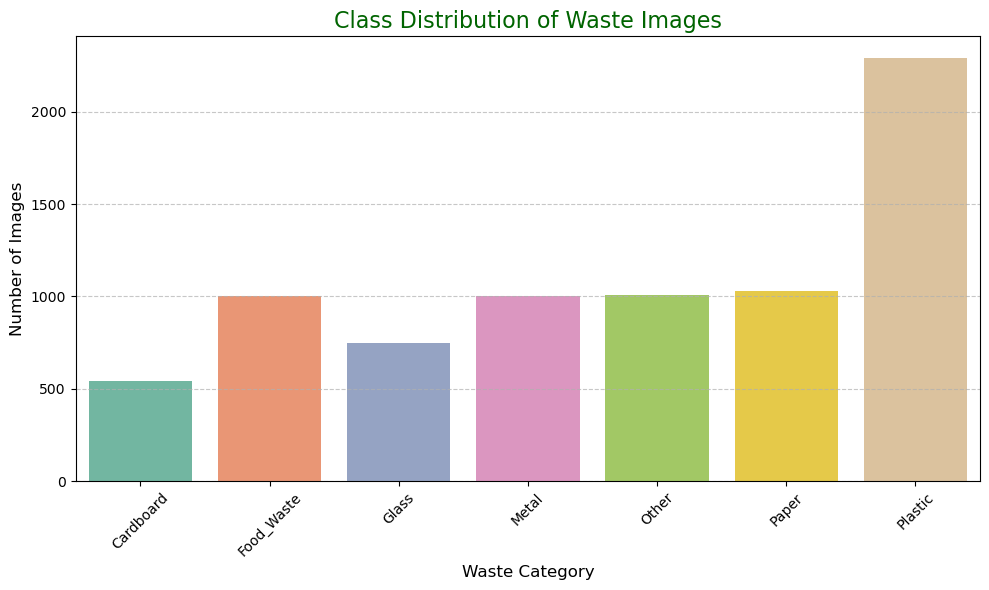

In [26]:
# Visualise Data Distribution
df = pd.DataFrame({'Label': y_raw})
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Label', hue='Label', palette='Set2')

plt.title("Class Distribution of Waste Images", fontsize=16, color='darkgreen')
plt.xlabel("Waste Category", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [28]:
# Visualise Sample Images (across different labels)
def visualize_images_by_label(label_type, num_images=6):
    target_indices = [i for i, label in enumerate(y_raw) if label == label_type]
    for i in range(num_images):
        plt.subplot(2,3, i+1)
        plt.imshow(X_raw[target_indices[i]])
        plt.axis("off")
    plt.suptitle(f'Images of {label_type}', fontsize=16, color='darkblue')
    plt.tight_layout()
    plt.show()

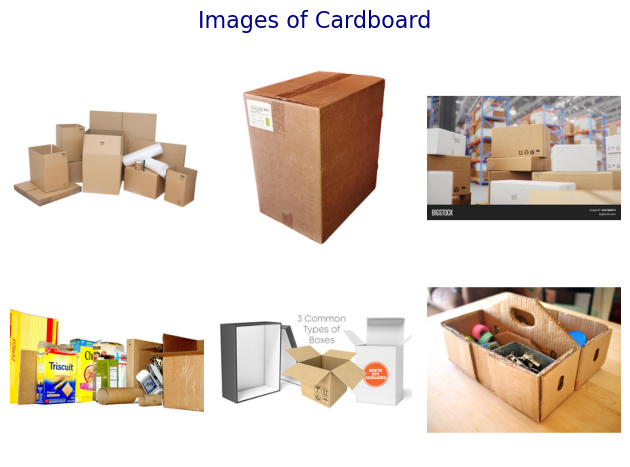

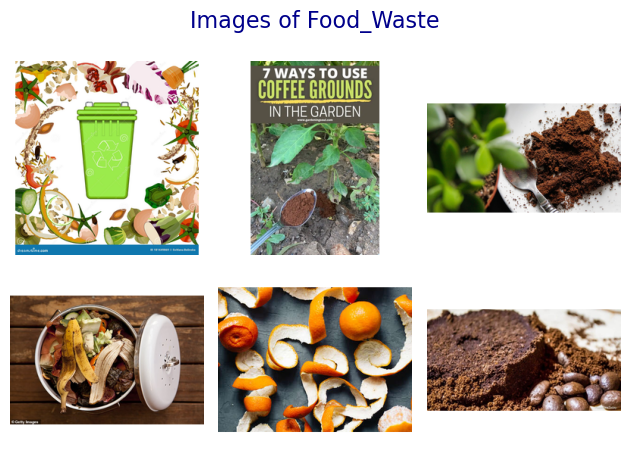

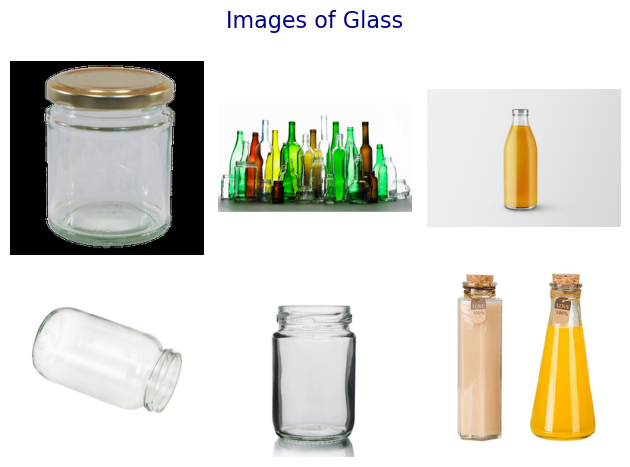

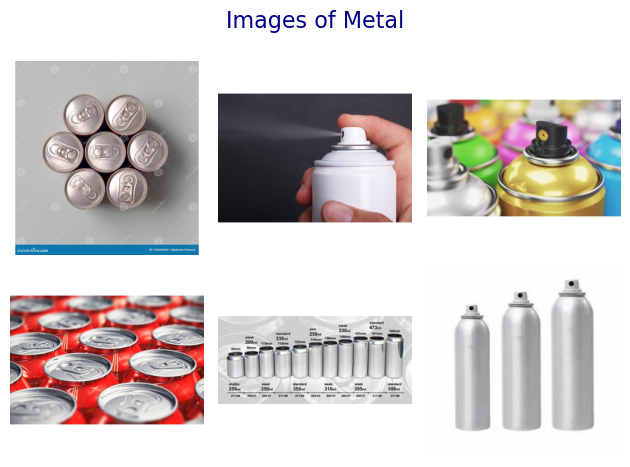

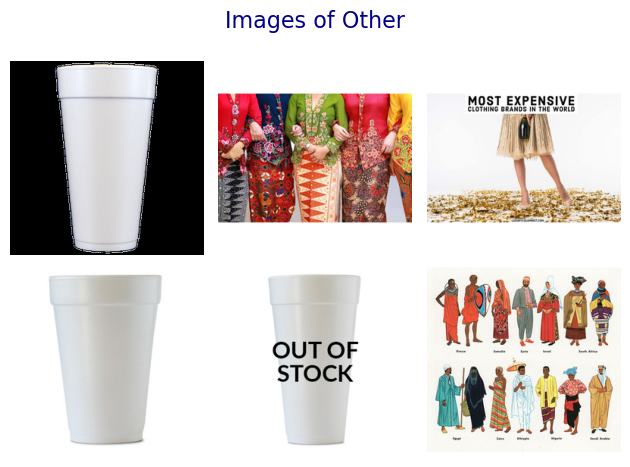

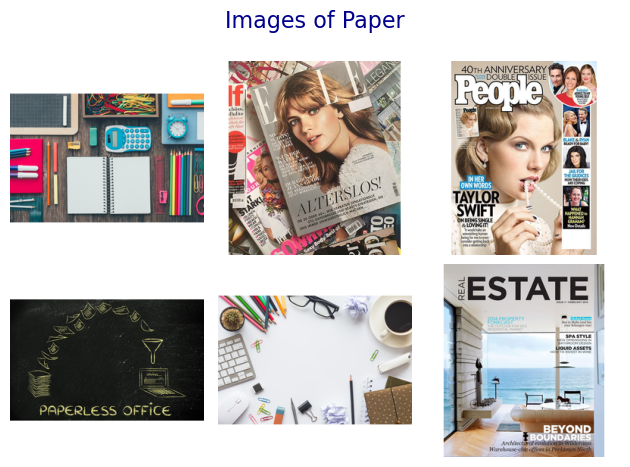

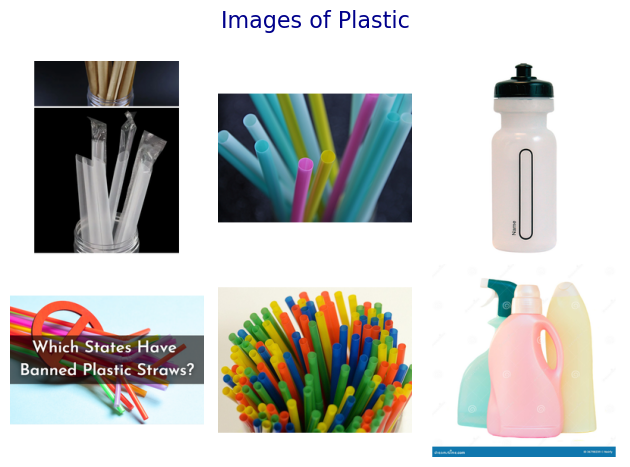

In [29]:
# visualize some 6 images from each label 
for i in label_names:
    visualize_images_by_label(i)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [31]:
# Find the smallest and largest image dimensions from the data set
image_shapes = [(img.size[1], img.size[0]) for img in X_raw]  # (height, width)

image_dim_tuple = [(h * w, h, w) for h, w in image_shapes]

min_area_tuple = min(image_dim_tuple, key=lambda x: x[0])
max_area_tuple = max(image_dim_tuple, key=lambda x: x[0])

print(f'Smallest image dimension: ({min_area_tuple[1]}, {min_area_tuple[2]}) with area: {min_area_tuple[0]}')
print(f'Largest image dimension: ({max_area_tuple[1]}, {max_area_tuple[2]}) with area: {max_area_tuple[0]}')

Smallest image dimension: (256, 256) with area: 65536
Largest image dimension: (256, 256) with area: 65536


In [32]:
# Resize the image dimensions
def resize_and_normilize(X_raw, size=(128, 128)):
    resized=[]
    for img in X_raw:
        img_resize=img.resize(size)
        resized.append(np.array(img_resize) / 255.0)
    return np.array(resized)

In [33]:
X_resized=resize_and_normilize(X_raw)
y_array=np.array(y_raw)

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [101]:
# Encode the labels suitably
le = LabelEncoder()
y_int=le.fit_transform(y_raw)

y_onehot = to_categorical(y_int)
print(f"Integer labels: {y_int[:5]}")
print(f"One-hot encoded labels: {y_onehot[:5]}")

Integer labels: [0 0 0 0 0]
One-hot encoded labels: [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [112]:
# Assign specified parts of the dataset to train and validation sets
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, train_test_ratio=0.8, file_types=('.jpg', '.jpeg', '.png'), seed=42):
    np.random.seed(seed)

    # Create train/test root dirs if not exists
    os.makedirs(training_data_dir, exist_ok=True)
    os.makedirs(testing_data_dir, exist_ok=True)
    
    num_training_files=0
    num_testing_files=0
    
    for subdir, dirs, files in os.walk(all_data_dir):
        # skip root directory
        if subdir == all_data_dir:
            continue
        
        category_name = os.path.basename(subdir)
        training_category_dir=os.path.join(training_data_dir, category_name)
        testing_category_dir=os.path.join(testing_data_dir, category_name)
        
        os.makedirs(training_category_dir, exist_ok=True)
        os.makedirs(testing_category_dir, exist_ok=True)
        
        file_list=[]
        for ext in file_types:
            file_list.extend(glob.glob(os.path.join(subdir, f'*{ext}')))
        
        print(f"{category_name} has {len(file_list)} images")
        
        random_set=np.random.permutation(file_list)
        split_index=int(len(random_set)*train_test_ratio)
        train_list=random_set[:split_index]
        test_list=random_set[split_index:]
        
        for f in train_list:
            shutil.copy(f, training_category_dir)
            num_training_files+=1

        for f in test_list:
            shutil.copy(f, testing_category_dir)
            num_testing_files+=1

        print(f"Processed {num_training_files} training files for {category_name}")
        print(f"Processed {num_testing_files} testing files for {category_name}")     
            


In [114]:
split_dataset_into_test_and_train_sets(
    all_data_dir='data',
    training_data_dir='data_split/train',
    testing_data_dir='data_split/val',
    train_test_ratio=0.8
)

Paper has 1030 images
Processed 824 training files
Processed 206 testing files
Food_Waste has 1000 images
Processed 1624 training files
Processed 406 testing files
Metal has 1000 images
Processed 2424 training files
Processed 606 testing files
Cardboard has 540 images
Processed 2856 training files
Processed 714 testing files
Other has 1010 images
Processed 3664 training files
Processed 916 testing files
Glass has 750 images
Processed 4264 training files
Processed 1066 testing files
Plastic has 2295 images
Processed 6100 training files
Processed 1525 testing files


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [45]:
# Build and compile the model



#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [48]:
# Training



### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [51]:
# Evaluate on the test set; display suitable metrics



## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [55]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [58]:
# Create a function to augment the images




In [59]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [61]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results